**3. NLP Pipeline**

**-Topic Analysis using LDA**

In [1]:
# Import Libraries 
import pandas as pd
import snscrape.modules.twitter as sntwitter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from gensim.utils import simple_preprocess
import gensim.downloader as api
import gensim.corpora as corpora

import nltk
nltk.download('stopwords') 
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('words')

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

import string
import re
import textblob
from textblob import TextBlob

from wordcloud import WordCloud, STOPWORDS
from wordcloud import ImageColorGenerator
from PIL import Image
from emot.emo_unicode import UNICODE_EMOJI

porter = PorterStemmer()
lemmatizer = WordNetLemmatizer() 

import pyLDAvis.gensim_models 
import pickle 
import pyLDAvis
import os

import warnings
from pprint import pprint
%matplotlib inline

c:\Users\pdhiman\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pdhiman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pdhiman\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pdhiman\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\pdhiman\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\pdhiman\AppData\Roaming\nltk_data...
[nltk_data

In [2]:
# Loading All the tweets 

df = pd.read_csv('data/tweets_final.csv')
df.head()

,Unnamed: 0,Date,ID,location,tweet,num_of_likes,num_of_retweet,language
0,0,2022-11-07 23:59:59+00:00,1589769667765469186,"California, USA",Taking into account personal contributions &am...,2,1,en
1,1,2022-11-07 23:59:59+00:00,1589769667652235267,@jlo follows ♡ 01.29.21,whats your fav song?\n\n❥ I’m voting #Jennifer...,0,10,en
2,2,2022-11-07 23:59:59+00:00,1589769667127934977,NaN,@MayoIsSpicyy He is allowed to speak his opini...,0,0,en
3,3,2022-11-07 23:59:59+00:00,1589769666918244352,USA,HEY NY DISTRICT 10! PLEASE VOTE FOR @danielsgo...,1,1,en
4,4,2022-11-07 23:59:59+00:00,1589769666679144448,DMV,@YDanasmithdutra @BaddCompani @politicalblond ...,3,0,en


Data Preproccessing 
- Clean Null Values
- Stopwords
- Punctuation Removal
- Removing Emojis
- Removing URLs and Usernames
- Removing Hashtags
- Lemmatization
- Remove Special characters (amp)

In [3]:
### Data Cleaning 

# Checking Locations which are NaN
df.location.isna().sum()

7809

In [4]:
### Data Cleaning 

# Replacing NaN location values with Unknown
df['location'] = df['location'].fillna('Unknown')
df.head()

,Unnamed: 0,Date,ID,location,tweet,num_of_likes,num_of_retweet,language
0,0,2022-11-07 23:59:59+00:00,1589769667765469186,"California, USA",Taking into account personal contributions &am...,2,1,en
1,1,2022-11-07 23:59:59+00:00,1589769667652235267,@jlo follows ♡ 01.29.21,whats your fav song?\n\n❥ I’m voting #Jennifer...,0,10,en
2,2,2022-11-07 23:59:59+00:00,1589769667127934977,Unknown,@MayoIsSpicyy He is allowed to speak his opini...,0,0,en
3,3,2022-11-07 23:59:59+00:00,1589769666918244352,USA,HEY NY DISTRICT 10! PLEASE VOTE FOR @danielsgo...,1,1,en
4,4,2022-11-07 23:59:59+00:00,1589769666679144448,DMV,@YDanasmithdutra @BaddCompani @politicalblond ...,3,0,en


In [5]:
### Data Cleaning 

# Dropping non english tweets.

df.drop(df[(df['language'] != 'en')].index, inplace=True)
df.head()

,Unnamed: 0,Date,ID,location,tweet,num_of_likes,num_of_retweet,language
0,0,2022-11-07 23:59:59+00:00,1589769667765469186,"California, USA",Taking into account personal contributions &am...,2,1,en
1,1,2022-11-07 23:59:59+00:00,1589769667652235267,@jlo follows ♡ 01.29.21,whats your fav song?\n\n❥ I’m voting #Jennifer...,0,10,en
2,2,2022-11-07 23:59:59+00:00,1589769667127934977,Unknown,@MayoIsSpicyy He is allowed to speak his opini...,0,0,en
3,3,2022-11-07 23:59:59+00:00,1589769666918244352,USA,HEY NY DISTRICT 10! PLEASE VOTE FOR @danielsgo...,1,1,en
4,4,2022-11-07 23:59:59+00:00,1589769666679144448,DMV,@YDanasmithdutra @BaddCompani @politicalblond ...,3,0,en


In [8]:
### Data Cleaning 

# Removing Emojis , URLs, @ , Stopwords etc.

words = set(nltk.corpus.words.words())
eng_stopwords = []
with open('data/stopwords.txt','r') as file:    
      for line in file:         
          for sw in line.split():            
              eng_stopwords.append(sw)
emoji = list(UNICODE_EMOJI.keys())

def ProcessedTweets(text):
    text = text.lower()  #changing tweet text to small letters 
    text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) |(\w+:\/\/\S+)", " ", text).split()) # Removing @ and links
    text = re.sub(r'\@\w+|\#\w+|\d+', '', text) # removing repeating characters
    punct = str.maketrans('', '', string.punctuation+string.digits) # removing punctuation and numbers
    text = text.translate(punct)
    
    tokens = word_tokenize(text)  # tokenizing words and removing stop words from the tweet text
    filtered_words = [w for w in tokens if w not in eng_stopwords] #check for stopwords, remove them
    filtered_words = [w for w in filtered_words if w not in emoji] #remove emoji

    #also removed the words not in NLTK words dictionary of set(nltk.corpus.words.words())
    filtered_words1 = [w2 for w2 in filtered_words if w2 in words or w2 in {'democrats', 'dem', 'dems'}]
    #check for synonyms using wordnet 
    
    # lemmetizing words
    lemmatizer = WordNetLemmatizer() 
    lemma_words = [lemmatizer.lemmatize(w) for w in filtered_words]
    text = " ".join(lemma_words)
    
    text = " ".join(filtered_words1) #without wordnet and lemmatizing
    return text

<>:15: DeprecationWarning: invalid escape sequence \w
<>:15: DeprecationWarning: invalid escape sequence \w
C:\Users\pdhiman\AppData\Local\Temp\ipykernel_36212\1580800783.py:15: DeprecationWarning: invalid escape sequence \w
  text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) |(\w+:\/\/\S+)", " ", text).split()) # Removing @ and links


In [6]:
## Cleaning Tweets data
eng_stop_words = list(stopwords.words('english'))
emoji = list(UNICODE_EMOJI.keys())

def preprocess_tweets(tweet):
    tweet = tweet.lower()  #lowercase
    tweet = re.sub('@[^\s]+','',tweet)  # Removing Usernames
    tweet = re.sub('http[^\s]+','',tweet) # Removing URLs.
    tweet = re.sub(r"www.\S+", "", tweet)
    tweet = re.sub("@[A-Za-z0-9_]+","", tweet) # Removing mentions
    tweet = re.sub("#[A-Za-z0-9_]+","", tweet) # Removing Hashtags
    tweet = re.sub(r"amp", "", tweet)

    punct = str.maketrans('', '', string.punctuation+string.digits) # Removing Punctuations
    tweet = tweet.translate(punct)

    # tokenizing words and removing stop words from the tweet text
    tokens = word_tokenize(tweet)  
    filtered_words = [w for w in tokens if w not in eng_stop_words]
    filtered_words = [w for w in filtered_words if w not in emoji]
    # lemmetizing words
    lemmatizer = WordNetLemmatizer() 
    lemma_words = [lemmatizer.lemmatize(w) for w in filtered_words]
    tweet = " ".join(lemma_words)

    return tweet


<>:7: DeprecationWarning: invalid escape sequence \s
<>:8: DeprecationWarning: invalid escape sequence \s
<>:7: DeprecationWarning: invalid escape sequence \s
<>:8: DeprecationWarning: invalid escape sequence \s
C:\Users\pdhiman\AppData\Local\Temp\ipykernel_36212\1815242603.py:7: DeprecationWarning: invalid escape sequence \s
  tweet = re.sub('@[^\s]+','',tweet)  # Removing Usernames
C:\Users\pdhiman\AppData\Local\Temp\ipykernel_36212\1815242603.py:8: DeprecationWarning: invalid escape sequence \s
  tweet = re.sub('http[^\s]+','',tweet) # Removing URLs.


In [9]:
df['Processed_Tweets'] = df['tweet'].apply(ProcessedTweets)
df.head()

,Unnamed: 0,Date,ID,location,tweet,num_of_likes,num_of_retweet,language,Processed_Tweets
0,0,2022-11-07 23:59:59+00:00,1589769667765469186,"California, USA",Taking into account personal contributions &am...,2,1,en,taking account personal bad everyone better tr...
1,1,2022-11-07 23:59:59+00:00,1589769667652235267,@jlo follows ♡ 01.29.21,whats your fav song?\n\n❥ I’m voting #Jennifer...,0,10,en,whats song voting
2,2,2022-11-07 23:59:59+00:00,1589769667127934977,Unknown,@MayoIsSpicyy He is allowed to speak his opini...,0,0,en,speak opinion like rest us opinion vote republ...
3,3,2022-11-07 23:59:59+00:00,1589769666918244352,USA,HEY NY DISTRICT 10! PLEASE VOTE FOR @danielsgo...,1,1,en,hey district please vote
4,4,2022-11-07 23:59:59+00:00,1589769666679144448,DMV,@YDanasmithdutra @BaddCompani @politicalblond ...,3,0,en,vote blue matter


Exploratory analysis 
- Generating Wordcloud to review most used words

c:\Users\pdhiman\Anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
c:\Users\pdhiman\Anaconda3\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
c:\Users\pdhiman\Anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
c:\Users\pdhiman\Anaconda3\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, fo

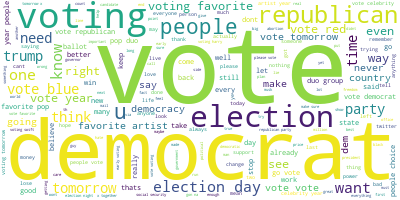

In [10]:
tweet_string = ','.join(list(df['Processed_Tweets'].values))  ## Joining processed tweets to form a string
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')  # Wordcloud Object
wordcloud.generate(tweet_string)  ## Generating wordcloud
wordcloud.to_image()

Preparing for LDA Analysis


In [11]:
# Converting document (in our case tweets)  to array for doc2bow to process and create bag of word Corpus. 

def sent2words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
data = df.Processed_Tweets.values.tolist()
data_words = list(sent2words(data))

In [12]:
id2word = corpora.Dictionary(data_words) # Create Dictionary
texts = data_words  # Create Corpus
corpus = [id2word.doc2bow(text) for text in texts] # Term Document Frequency

print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)]


In [13]:
print(id2word)

Dictionary(8550 unique tokens: ['account', 'bad', 'best', 'better', 'blue']...)


Building a LDA Model

In [14]:
num_topics = 10  # number of topics
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.035*"election" + 0.032*"voting" + 0.014*"vote" + 0.013*"like" + '
  '0.011*"tomorrow" + 0.010*"democrats" + 0.010*"people" + 0.009*"us" + '
  '0.009*"get" + 0.009*"one"'),
 (1,
  '0.060*"vote" + 0.043*"voting" + 0.028*"people" + 0.017*"democrats" + '
  '0.016*"election" + 0.012*"year" + 0.009*"red" + 0.008*"day" + 0.008*"like" '
  '+ 0.008*"republican"'),
 (2,
  '0.067*"vote" + 0.018*"election" + 0.014*"democrats" + 0.013*"year" + '
  '0.010*"would" + 0.009*"republican" + 0.009*"right" + 0.009*"time" + '
  '0.008*"blue" + 0.008*"get"'),
 (3,
  '0.044*"election" + 0.020*"democrats" + 0.018*"vote" + 0.017*"people" + '
  '0.017*"voting" + 0.017*"republican" + 0.013*"like" + 0.010*"day" + '
  '0.009*"year" + 0.008*"get"'),
 (4,
  '0.105*"vote" + 0.020*"republican" + 0.020*"tomorrow" + 0.016*"democrats" + '
  '0.016*"election" + 0.014*"voting" + 0.010*"day" + 0.008*"blue" + 0.007*"us" '
  '+ 0.007*"party"'),
 (5,
  '0.038*"vote" + 0.027*"election" + 0.024*"democrats" + 0.018*"voti

Assigning each tweet with an identified topic

In [15]:
topic_dict = {'dominant_topic':[], 'perc_contribution':[], 'topic_keywords':[]}

for i, row in enumerate(lda_model[corpus]):
    
    row = sorted(row, key=lambda x: x[1], reverse=True)
    for j, (topic_num, prop_topic) in enumerate(row):
        wp = lda_model.show_topic(topic_num)
        topic_keywords = ", ".join([word for word, prop in wp])
        topic_dict['dominant_topic'].append(int(topic_num))
        topic_dict['perc_contribution'].append(round(prop_topic, 3))
        topic_dict['topic_keywords'].append(topic_keywords)
        break

df_topics = pd.DataFrame(topic_dict)
contents = pd.Series(texts)

#df_topics['post'] = df['post']
df_topics.head()

,dominant_topic,perc_contribution,topic_keywords
0,1,0.959,"vote, voting, people, democrats, election, yea..."
1,7,0.775,"voting, vote, election, republican, favorite, ..."
2,4,0.940,"vote, republican, tomorrow, democrats, electio..."
3,8,0.820,"vote, election, voting, dont, year, tomorrow, ..."
4,4,0.775,"vote, republican, tomorrow, democrats, electio..."


Analysis LDA Model Results with pyLDAvis
- Top 10 Topics


In [16]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(num_topics))
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

c:\Users\pdhiman\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.035663  0.005183       1        1  18.278192
1     -0.013867  0.009509       2        1  16.350274
7      0.004184  0.075396       3        1  10.001599
3      0.047342 -0.021916       4        1   9.551498
2     -0.057286 -0.043674       5        1   8.731644
8     -0.035484  0.017315       6        1   8.447441
9      0.040796 -0.056669       7        1   7.452985
6     -0.025925 -0.013896       8        1   7.295283
5      0.019751  0.014057       9        1   7.174412
0      0.056152  0.014695      10        1   6.716672, topic_info=           Term         Freq        Total Category  logprob  loglift
18         vote  9037.000000  9037.000000  Default  30.0000  30.0000
130    election  3862.000000  3862.000000  Default  29.0000  29.0000
20       voting  3747.000000  3747.000000  Default  28.0000  28.0000
23    democrats  2549.000000  2549.000000  Default  27.0000  27.0000
105    favorite   899.000000   899.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
18         vote   147.414051  9037.752142  Topic10  -4.2783  -1.4153
312         win    37.243098   460.637915  Topic10  -5.6541   0.1854
57           go    41.439226   642.348707  Topic10  -5.5474  -0.0403
14   republican    48.599357  1874.591451  Topic10  -5.3880  -0.9520
17        trump    38.198290   620.134955  Topic10  -5.6288  -0.0866

[854 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
7735      2  0.617944    abnormal
5517      3  0.232296     absence
5517      5  0.696887     absence
7761      1  0.875628      absent
336       1  0.153047  absolutely
...     ...       ...         ...
75        6  0.079408         yes
75        7  0.046923         yes
75        8  0.043313         yes
75        9  0.054142         yes
75       10  0.064970         yes

[2480 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 8, 4, 3, 9, 10, 7, 6, 1])